In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import config
from utils import compute_frames

In [2]:
import torch
from torch.utils.data import Dataset

# History dataset generation

In [3]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [4]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [5]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

In [6]:
# counties
frames_county = pd.read_csv(config.TR_COUNTIES, index_col=0)
counties_defor = pd.read_csv(config.TR_COUNTIES_DEFOR, index_col=0)

In [7]:
# precipitations
precip = pd.read_csv(config.TR_RAIN_AVG)
precip["quarter_date"] = pd.to_datetime(precip["dt"])

In [8]:
# terrain position index
tpi = pd.read_csv(config.TR_TPI, skiprows=1)\
    .rename(columns={"Unnamed: 0": "frame_id"})

In [9]:
# land cover
landcover = pd.read_csv(config.TR_LANDCOVER)
landcover = pd.pivot_table(
    landcover, 
    index=["frame_id"], 
    columns=["landcover"], 
    values="geometry", 
    aggfunc="sum"
).fillna(0).astype(int)
# convert to percentage
sum_by_frame = landcover.sum(axis=1)
for col in landcover.columns:
    landcover[col] = landcover[col] / sum_by_frame

## Create grid

In [10]:
# create limits history grid
time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in enumerate(config.TIME_STEPS):
    defor_area = (
        deforestation[
            deforestation["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)

In [11]:
time_grid.shape

(28, 1002, 778)

# Counties data

## Population and density

In [12]:
county_data = np.zeros((2, frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
county_data[0] = (
    frames_county.set_index("frame_id")["populacao"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

county_data[1] = (
    frames_county.set_index("frame_id")["densidade"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

## Deforestation

In [13]:
frames_counties_defor = pd.merge(
    counties_defor,
    frames_county[["frame_id", "county_id"]],
    on="county_id",
    how="right"
)
frames_counties_defor["quarter_date"] = pd.to_datetime(frames_counties_defor["quarter_date"])

In [14]:
# create limits history grid
counties_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    defor_area = (
        frames_counties_defor[
            frames_counties_defor["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    counties_time_grid[t, :, :] = defor_area.values.reshape(counties_time_grid[0, :, :].shape)

0it [00:00, ?it/s]

28it [00:10,  2.68it/s]


In [15]:
counties_time_grid.shape

(28, 1002, 778)

# Precipitations

In [16]:
# create limits history grid
precip_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    precip_sum = (
        precip[
            precip["quarter_date"] == dt
        ].set_index("frame_id")["precipitation"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    precip_time_grid[t, :, :] = precip_sum.values.reshape(counties_time_grid[0, :, :].shape)

1it [00:00,  3.44it/s]

28it [00:07,  3.85it/s]


In [17]:
precip_time_grid.shape

(28, 1002, 778)

# Terrain Position Index

In [18]:
cols = ["mean", "min", "max", "std"]
tpi_array = np.zeros((len(cols), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for icol, col in enumerate(cols):
    v = (
        tpi.set_index("frame_id")[col] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    tpi_array[icol, :, :] = v.values.reshape(tpi_array[0, :, :].shape)

In [19]:
tpi_array.shape

(4, 1002, 778)

# Land Cover

In [30]:
landcover_categories = [[20], [40, 50], [180]]
landcover_array = np.zeros((len(landcover_categories), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for i, cols in enumerate(landcover_categories):
    v = (
        landcover[cols].sum(axis=1) +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    landcover_array[i, :, :] = v.values.reshape(landcover_array[0, :, :].shape)

In [37]:
landcover_array.shape

(3, 1002, 778)

# Compute frame patches

A patch is squared set of unitary frames. The patch formation process consists in iterating through the full image on both axis computing the frames corresponding to each iteration.

In [38]:
out_condition = "borders"  # deforestation | borders

bundle_step = 32
patches = []
for ix in tqdm(list(range(frames_idx["x"].min(), frames_idx["x"].max()+1, bundle_step))):
    fx = ix + config.INPUT_BOXES_SIZE
    for iy in range(frames_idx["y"].min(), frames_idx["y"].max()+1, bundle_step):
        fy = iy + config.INPUT_BOXES_SIZE

        iframes = frames_idx[
            (frames_idx["x"] >= ix) & 
            (frames_idx["x"] < fx) &
            (frames_idx["y"] >= iy) &
            (frames_idx["y"] < fy)
        ]
        
        if out_condition == "borders":
            if iframes["in_borders"].mean() >= 0.5:  # condition: bundle has to be at least half inside borders
                patches.append(iframes.index)
                
        elif out_condition == "deforestation":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if out_of_borders_frames < len(iframes):  # condition: bundle has to contain  some deforestation
                patches.append(iframes.index)        

100%|██████████| 32/32 [00:05<00:00,  6.32it/s]


In [39]:
# remove patches that represent reduced regions
patches = [b for b in patches if (len(b)==len(patches[0]))]

In [40]:
len(patches)

441

In [41]:
patches[0]

Index([  288,   289,   290,   291,   292,   293,   294,   295,   296,   297,
       ...
       49356, 49357, 49358, 49359, 49360, 49361, 49362, 49363, 49364, 49365],
      dtype='int64', length=4096)

In [42]:
# generate region and check which patches intersect
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 200, 300, 500, 600)

41


42
43
44
45
53
54
55
56
57


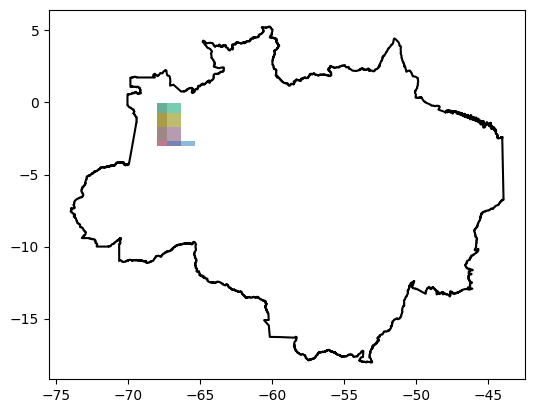

In [43]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
j = 0
for i, b in enumerate(patches):
    int_b = region[region["frame_id"].isin(b)]
    if len(int_b) > 0:
        int_b.plot(ax=ax, color=sns.color_palette()[j%10], alpha=.5)
        j+=1
        if j > 10:
            break
        print(i)
plt.show()

# Train test split

In [44]:
time_grid.shape

(28, 1002, 778)

In [45]:
train_time_idx = range(8,20)
test_time_idx = range(20,28)

train_data = time_grid[train_time_idx, :, :]
test_data = time_grid[test_time_idx, :, :]

# Data Normalization

In [46]:
one_multiplicator_factor = (train_data <= 1e-7).sum() / (train_data > 1e-7).sum()

In [47]:
norm_pop = (county_data[0, :, :] - np.median(county_data[0, :, :])) / 1e5
norm_den = (county_data[1, :, :] - np.median(county_data[1, :, :])) / 30

county_data[0, :, :] = norm_pop
county_data[1, :, :] = norm_den

In [48]:
counties_time_grid = (counties_time_grid-counties_time_grid[train_time_idx, :, :].mean()) / counties_time_grid[train_time_idx, :, :].std()

In [49]:
precip_time_grid = (precip_time_grid-precip_time_grid[train_time_idx, :, :].mean()) / precip_time_grid[train_time_idx, :, :].std()

In [50]:
for i in range(tpi_array.shape[0]):
    tpi_array[i, :, :] = (tpi_array[i, :, :] - tpi_array[i, :, :].mean()) / tpi_array[i, :, :].std()

# Loss function

In [51]:
def WeightedBinaryCrossEntropy(target, prediction):
    return -(one_multiplicator_factor*target*prediction.log() + (1-target)*((1-prediction).log()))

# Dataset & Dataloaders

In [52]:
len(patches) * (time_grid.shape[0] - 4)

10584

In [53]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X, 
        patches, 
        frames_idx, 
        county_data=None, 
        county_defor=None,
        precip_data=None,
        tpi_data=None,
        landcover_data=None
    ):
        super(CustomDataset, self).__init__()

        self.patches = patches
        self.frames_idx = frames_idx
        self.X = X
        self.county_data = county_data
        self.county_defor = county_defor
        self.precip_data = precip_data
        self.tpi_data = tpi_data
        self.landcover_data = landcover_data
        self.autor_window = 4
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()

    def __len__(self):
        return len(self.patches) * (self.X.shape[0]-self.autor_window)

    def __getitem__(self, index):

        # get index info
        idx_patch = index // (self.X.shape[0] - self.autor_window)
        idx_time   = index % (self.X.shape[0] - self.autor_window)
        idx_frames = self.frames_idx.loc[self.patches[idx_patch]]

        # get input
        input_matrix = self.X[
            idx_time:idx_time+self.autor_window, 
            idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
            idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        ]

        if self.county_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.county_defor is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_defor[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.precip_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.precip_data[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.tpi_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.tpi_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.landcover_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.landcover_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        data = torch.tensor(input_matrix).float()

        # get output
        labels = torch.tensor(
            self.X[
                idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ] > 1e-7
        ).float()
        return data, labels

In [54]:
train_data.shape, test_data.shape

((12, 1002, 778), (8, 1002, 778))

In [55]:
# patches_sample_train = [patches[i] for i in np.random.choice(range(len(patches)), 100, replace=False)]
# patches_sample_test = [patches[i] for i in np.random.choice(range(len(patches)), 10, replace=False)]

patches_sample_train = patches[:1]
patches_sample_test = patches[1:2]

In [56]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(
        train_data, 
        patches_sample_train, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array
    ),
    batch_size=40,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches_sample_test, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array
    ),
    batch_size=40,
    shuffle=False
)

In [57]:
trainloader.__len__()*trainloader.batch_size, testloader.__len__()*testloader.batch_size

(40, 40)

# Baseline Model

Just test the metrics we get when always predicting zeros.

In [58]:
# baseline: all 50%
base_train_err = 0
for inputs, labels in trainloader:
    y_pred = torch.tensor(0.5*np.ones(labels.shape))
    # base_train_err -= (y_pred*labels).float().mean()
    base_train_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
base_train_err = base_train_err / (len(trainloader)*trainloader.batch_size)
    
base_test_err = 0
for inputs, labels in testloader:
    y_pred = torch.tensor(0.5*np.ones(labels.shape))
    # base_test_err -= (y_pred*labels).float().mean()
    base_test_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
base_test_err = base_test_err / (len(testloader)*testloader.batch_size)

print(f"Baseline: Train Loss = {base_train_err:.6f} | Test Loss = {base_test_err:.6f}")

Baseline: Train Loss = 0.036758 | Test Loss = 0.047534


In [59]:
inputs.shape

torch.Size([4, 21, 64, 64])

# Model Implementation

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

ks = 7
 
class BasicConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.epoch = 0
        self.errs = []

        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(4+2+4+4+4+3, 64, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.Conv2d(64, 1, kernel_size=(ks,ks), stride=1, padding=int(ks/2)),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        y = self.convolutional_layer(x)
        return y

In [100]:
# model initialization
model = BasicConvModel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [101]:
# model.load_state_dict(torch.load(r"basic_cnn_003.pt"))

In [102]:
print(model)

BasicConvModel(
  (convolutional_layer): Sequential(
    (0): Conv2d(21, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(7, 7), stride=1, padding=3, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (8): Sigmoid()
  )
)


In [103]:
for data, target in trainloader:
    break

In [104]:
data.shape, target.shape

(torch.Size([8, 21, 64, 64]), torch.Size([8, 64, 64]))

In [105]:
pred = model(data).detach()

In [106]:
target.min()

tensor(0.)

In [107]:
pred[0, 0, 0, 0], target[0, 0, 0]

(tensor(0.5637), tensor(0.))

In [108]:
pred.shape, target.shape

(torch.Size([8, 1, 64, 64]), torch.Size([8, 64, 64]))

In [109]:
(pred[:, 0, :, :]*target).shape

torch.Size([8, 64, 64])

In [110]:
(pred[:, 0, :, :] - target).multiply(np.exp(target)).shape

torch.Size([8, 64, 64])

In [111]:
# train loop
errs = []

def train(n_epochs):

    for epoch in range(n_epochs):
        print(f"\nEpoch {model.epoch}")
        if model.epoch >= 1:
            for inputs, labels in tqdm(trainloader):
                y_pred = model(inputs)[:, 0, :, :]
                # evaluate loss ignoring the borders
                # l = (y_pred - labels).multiply(np.exp(labels))
                # l = -y_pred*labels
                l = WeightedBinaryCrossEntropy(labels, y_pred)
                loss = l.mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        train_err = 0
        for inputs, labels in trainloader:
            y_pred = model(inputs)[:, 0, :, :]
            # train_err += torch.square(y_pred - labels).detach().float().sum()
            # train_err -= (y_pred * labels).detach().float().mean()
            train_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
        train_err = train_err / (len(trainloader)*trainloader.batch_size)
            
        test_err = 0
        for inputs, labels in testloader:
            y_pred = model(inputs)[:, 0, :, :]
            # test_err += torch.square(y_pred - labels).detach().float().sum()
            # test_err -= (y_pred * labels).detach().float().mean()
            test_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
        test_err = test_err / len(testloader)
        model.errs.append([train_err, test_err])

        print(f"Epoch {model.epoch}: Train Loss = {train_err:.6f} | Test Loss = {test_err:.6f}")
        
        model.epoch += 1

train(10)


Epoch 0
Epoch 0: Train Loss = 0.041918 | Test Loss = 1.967716

Epoch 1


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch 1: Train Loss = 0.030416 | Test Loss = 1.756614

Epoch 2


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Epoch 2: Train Loss = 0.025621 | Test Loss = 1.930892

Epoch 3


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 3: Train Loss = 0.023154 | Test Loss = 2.138068

Epoch 4


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 4: Train Loss = 0.022707 | Test Loss = 2.457906

Epoch 5


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 5: Train Loss = 0.021828 | Test Loss = 2.791626

Epoch 6


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch 6: Train Loss = 0.021378 | Test Loss = 3.092015

Epoch 7


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch 7: Train Loss = 0.021337 | Test Loss = 3.248930

Epoch 8


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch 8: Train Loss = 0.019238 | Test Loss = 3.118769

Epoch 9


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Epoch 9: Train Loss = 0.018969 | Test Loss = 2.977077


In [112]:
train(30)


Epoch 10


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch 10: Train Loss = 0.018681 | Test Loss = 2.913347

Epoch 11


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch 11: Train Loss = 0.017823 | Test Loss = 2.968355

Epoch 12


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch 12: Train Loss = 0.018163 | Test Loss = 3.115881

Epoch 13


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch 13: Train Loss = 0.017439 | Test Loss = 3.116460

Epoch 14


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch 14: Train Loss = 0.017502 | Test Loss = 3.141757

Epoch 15


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 15: Train Loss = 0.017243 | Test Loss = 3.241217

Epoch 16


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch 16: Train Loss = 0.016634 | Test Loss = 3.408217

Epoch 17


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch 17: Train Loss = 0.016610 | Test Loss = 3.593690

Epoch 18


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 18: Train Loss = 0.015895 | Test Loss = 3.658147

Epoch 19


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 19: Train Loss = 0.015682 | Test Loss = 3.743016

Epoch 20


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Epoch 20: Train Loss = 0.015348 | Test Loss = 3.877495

Epoch 21


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch 21: Train Loss = 0.015072 | Test Loss = 4.021336

Epoch 22


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch 22: Train Loss = 0.014984 | Test Loss = 4.093797

Epoch 23


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch 23: Train Loss = 0.014608 | Test Loss = 4.055414

Epoch 24


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 24: Train Loss = 0.014559 | Test Loss = 4.040420

Epoch 25


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch 25: Train Loss = 0.014212 | Test Loss = 4.070871

Epoch 26


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch 26: Train Loss = 0.014039 | Test Loss = 4.122838

Epoch 27


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch 27: Train Loss = 0.013779 | Test Loss = 4.089817

Epoch 28


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 28: Train Loss = 0.013566 | Test Loss = 4.001094

Epoch 29


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Epoch 29: Train Loss = 0.013457 | Test Loss = 3.970480

Epoch 30


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Epoch 30: Train Loss = 0.013243 | Test Loss = 4.022384

Epoch 31


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 31: Train Loss = 0.013119 | Test Loss = 4.095542

Epoch 32


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 32: Train Loss = 0.012852 | Test Loss = 4.140229

Epoch 33


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch 33: Train Loss = 0.012672 | Test Loss = 4.238979

Epoch 34


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch 34: Train Loss = 0.012450 | Test Loss = 4.352251

Epoch 35


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 35: Train Loss = 0.012280 | Test Loss = 4.392487

Epoch 36


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch 36: Train Loss = 0.012124 | Test Loss = 4.346439

Epoch 37


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch 37: Train Loss = 0.011907 | Test Loss = 4.344507

Epoch 38


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Epoch 38: Train Loss = 0.011805 | Test Loss = 4.390390

Epoch 39


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch 39: Train Loss = 0.011572 | Test Loss = 4.312196


Ganhamos do baseline?

In [113]:
(
    float(model.errs[-1][0] - base_train_err), 
    float(model.errs[-1][1] - base_test_err)
)

(-0.025186318904161453, 4.26466178894043)

Curva de aprendizado

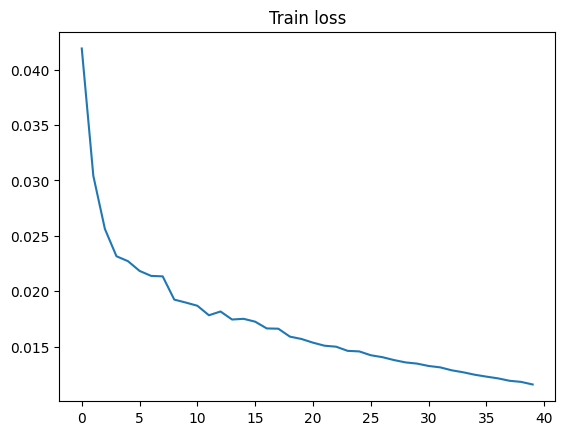

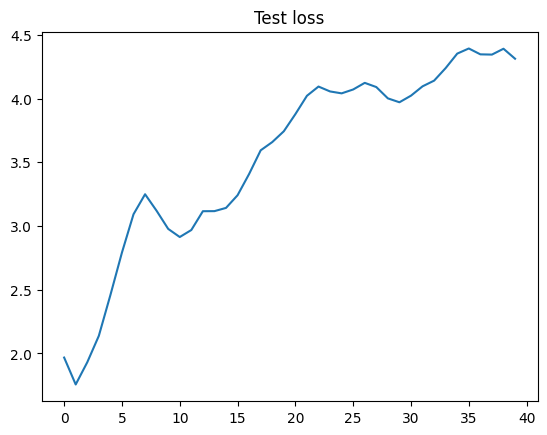

In [114]:
import matplotlib.pyplot as plt

plt.plot([float(e[0]) for e in model.errs])
plt.title("Train loss")
plt.show()
plt.plot([float(e[1]) for e in model.errs])
plt.title("Test loss")
plt.show()

Exemplo de previsão

In [115]:
time_grid.shape

(28, 1002, 778)

In [116]:
for input_, truth in trainloader:
    if np.random.random() < 0.5:
        print("ok")
        break

pred = model(input_)[:, 0, :, :]

ok


In [117]:
# region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 450, 514, 80, 144)
# t = 27

# truth = time_grid[t, region["x"].min():region["x"].max()+1, region["y"].min():region["y"].max()+1]
# input_ = time_grid[t-4:t, region["x"].min():region["x"].max()+1, region["y"].min():region["y"].max()+1]
# input_ = input_.reshape(1,*input_.shape)
# pred = model(torch.tensor(input_).float())[0, :, :].detach().numpy()

In [118]:
idx_batch = 0
truth[idx_batch, :, :].min(), truth[idx_batch, :, :].max()

(tensor(0.), tensor(1.))

In [119]:
truth.shape

torch.Size([8, 64, 64])

In [120]:
input_.shape

torch.Size([8, 21, 64, 64])

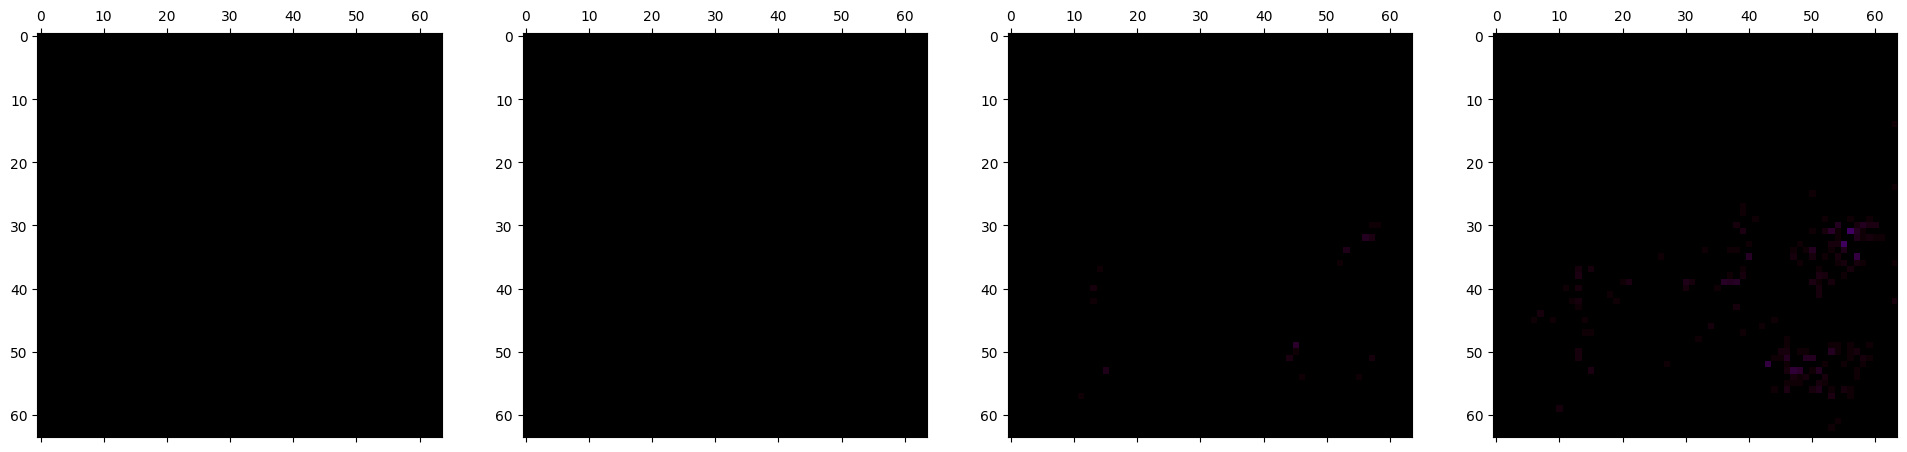

In [121]:
fig, ax = plt.subplots(1, 4, figsize=(24, 8))
for i in range(4):
    ax[i].matshow(input_[idx_batch, i, :, :], cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
plt.show()

C:\Users\GiovanniAmorim\AppData\Local\Temp\ipykernel_1036\1877127924.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


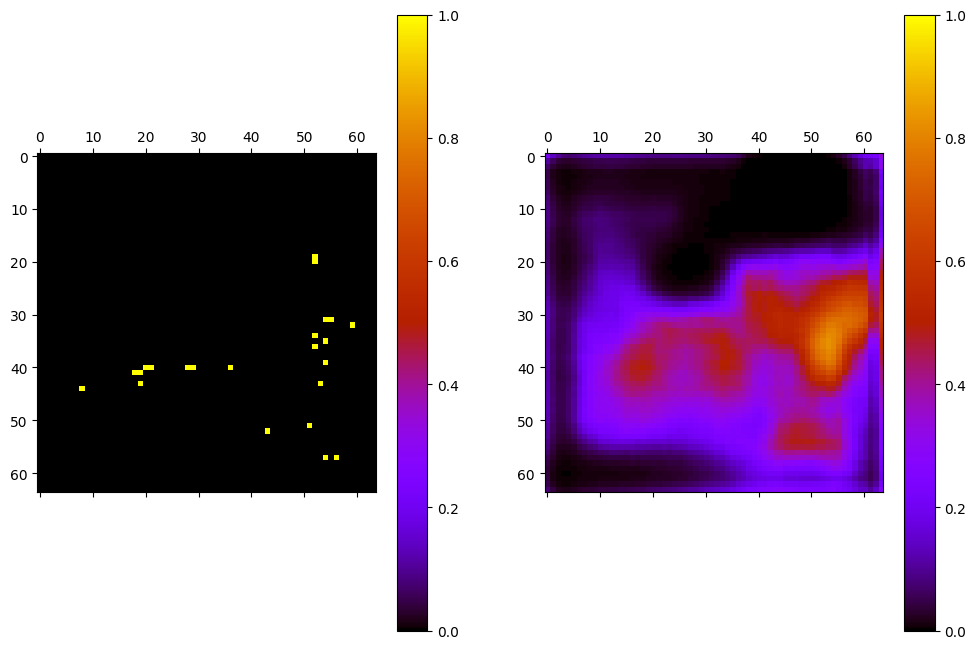

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
m1 = ax[0].matshow(truth[idx_batch, :, :], cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
m2 = ax[1].matshow(pred.detach().numpy()[idx_batch, :, :], cmap="gnuplot", vmin=truth.min(), vmax=1)
fig.colorbar(m1)
fig.colorbar(m2)
fig.show()

# Save model

In [107]:
# torch.save(model.state_dict(), r"cnn_40.pt")